In [18]:
pip install river==0.21.0

Note: you may need to restart the kernel to use updated packages.


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
#import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from scipy.stats import shapiro
#import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from river import metrics
import time

In [20]:
dfd = pd.read_csv("Desktop/projects/Ml_Edge_new_binary_hho_Selected_Features.csv")


In [24]:
dfd = dfd.sample(frac=0.1)

In [27]:
dfd.head(5)
print(dfd['Attack_label'].value_counts())

Attack_label
1    13386
0     2394
Name: count, dtype: int64


In [29]:
def adaptive_learning(model, X_train, y_train, X_test, y_test):
    metric = metrics.Accuracy() # Use accuracy as the metric
    i = 0 # count the number of evaluated data points
    t = [] # record the number of evaluated data points
    m = [] # record the real-time accuracy
    yt = [] # record all the true labels of the test set
    yp = [] # record all the predicted labels of the test set
    
    eddm = drift.binary.EDDM()
    #detector = EDDM()
    
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)  # Encode training labels
    y_test = le.transform(y_test)  # Encode test labels


    
    # Learn the training set
    for xi1, yi1 in zip(X_train.values, y_train): 
        xi = dict(zip(X_train.columns, xi1))   
        model.learn_one(xi, yi1) 

    # Predict the test set and perform drift detection
    for x_val, y_val in zip(X_test.values, y_test):
        x = dict(zip(X_test.columns, x_val))
        y_pred = (model.predict_one(x))  # Convert to nearest class label
  # Predict the test sample
        model.learn_one(x, y_val) # Learn the test sample
        metric.update(y_val, y_pred) # Update the real-time accuracy
        
        # Drift detection part
        val = 0
        
        if y_val != y_pred:
           val = 1 
           eddm.update(y_val)
        if eddm.drift_detected:
            print(f"Change detected at index {i}, input value: {y_val}")
            
           
        if eddm.warning_detected:
           print(f"Warning detected at index {i}")
        # Print samples every 80 iterations
        #if i % 80 == 0:
           # print(f"Sample {i}: True label: {y_val}, Predicted label: {y_pred}") 

        # Performance evaluation
        t.append(i)
        m.append(metric.get() * 100)
        yt.append(y_val)
        yp.append(y_pred)
        i += 1
        

    print("Accuracy: " + str(round(accuracy_score(yt, yp), 4) * 100) + "%")
    print("Precision: " + str(round(precision_score(yt, yp), 4) * 100) + "%")
    print("Recall: " + str(round(recall_score(yt, yp), 4) * 100) + "%")
    print("F1-score: " + str(round(f1_score(yt, yp), 4) * 100) + "%")

    return t, m

In [31]:
# Define a figure function that shows the real-time accuracy changes
def acc_fig(t, m, name):
    plt.rcParams.update({'font.size': 15})
    plt.figure(1,figsize=(10,6)) 
    sns.set_style("darkgrid")
    plt.clf() 
    #if m:  # Check if m is not empty
    plt.plot(t, m, '-b', label='Avg Accuracy: %.2f%%' % (m[-1]))

    #plt.plot(t,m,'-b',label='Avg Accuracy: %.2f%%'%(m[-1]))

    plt.legend(loc='best')
    plt.title(name+' on Farmflow dataset', fontsize=15)
    plt.xlabel('Number of samples')
    plt.ylabel('Accuracy (%)')

    plt.draw()

In [33]:
from river import forest
from river import drift

Accuracy: 99.98%
Precision: 99.97%
Recall: 100.0%
F1-score: 99.99%
CPU times: total: 1.89 s
Wall time: 7.05 s


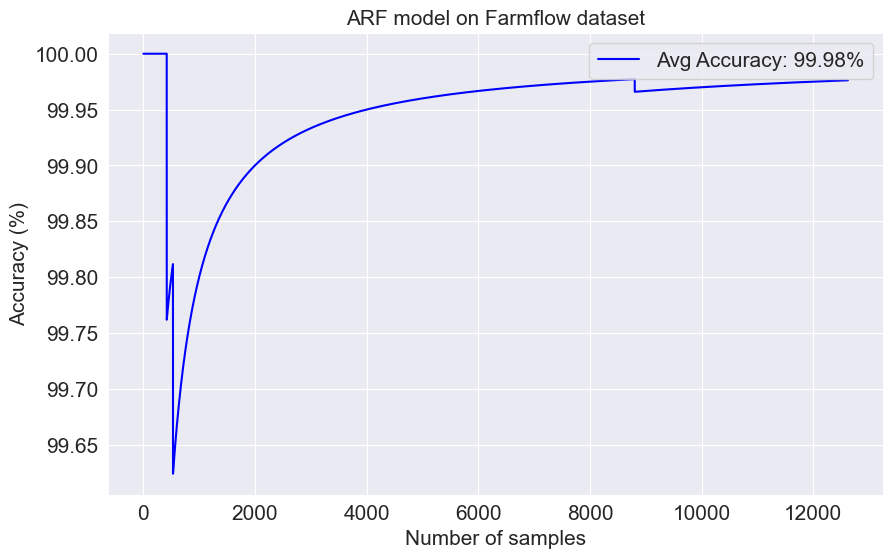

In [35]:
get_ipython().run_cell_magic('time', '', '# Use the Adaptive Random Forest (ARF) model with ADWIN drift detector as a baseline model\nname = "ARF model"\n\n\nmodel = drift.DriftRetrainingClassifier(\n    model=forest.ARFClassifier(n_models = 3,drift_detector=drift.binary.EDDM())\n    \n)\n\nt, m = adaptive_learning(model, X_train, y_train, X_test, y_test) # Learn the model on the dataset\nacc_fig(t, m, name) # Draw the figure of how the real-time accuracy changes with the number of samples\n')

Change detected at index 2411, input value: 1
Change detected at index 2412, input value: 1
Change detected at index 2413, input value: 1
Change detected at index 2414, input value: 1
Change detected at index 2415, input value: 0
Change detected at index 2416, input value: 1
Change detected at index 2417, input value: 1
Change detected at index 2418, input value: 1
Change detected at index 2419, input value: 1
Change detected at index 2420, input value: 1
Change detected at index 2421, input value: 1
Change detected at index 2422, input value: 1
Warning detected at index 8697
Warning detected at index 8698
Warning detected at index 8699
Warning detected at index 8700
Warning detected at index 8701
Warning detected at index 8702
Warning detected at index 8703
Warning detected at index 8704
Warning detected at index 8705
Warning detected at index 8706
Warning detected at index 8707
Warning detected at index 8708
Warning detected at index 8709
Warning detected at index 8710
Warning detect

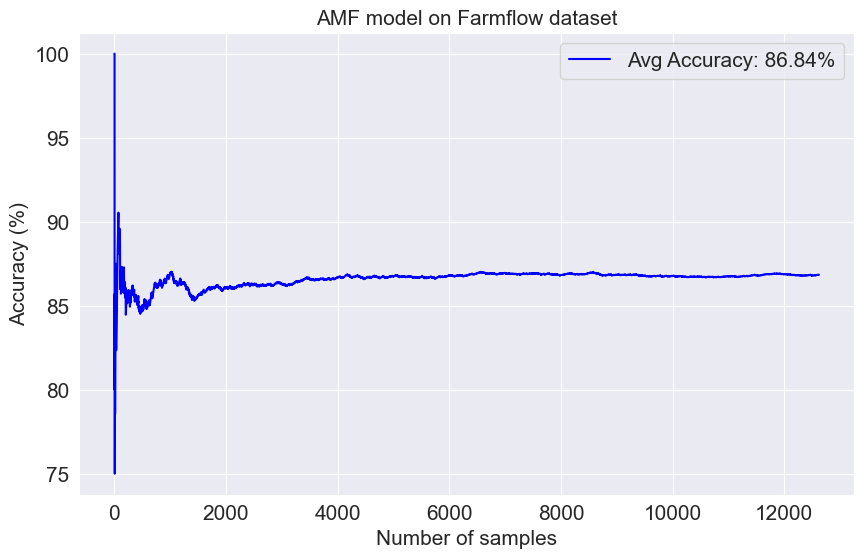

In [39]:
get_ipython().run_cell_magic('time', '', '# Use the Aggregated Mondrian Forest (AMF) model with ADWIN drift detector as a baseline model\nname = "AMF model"\n\n\nmodel=forest.AMFClassifier(n_estimators = 3,use_aggregation=True)\n    \n\nt, m = adaptive_learning(model, X_train, y_train, X_test, y_test) # Learn the model on the dataset\nacc_fig(t, m, name) # Draw the figure of how the real-time accuracy changes with the number of samples\n')


In [40]:
from river import tree

Accuracy: 99.98%
Precision: 99.97%
Recall: 100.0%
F1-score: 99.99%
CPU times: total: 4.92 s
Wall time: 9.06 s


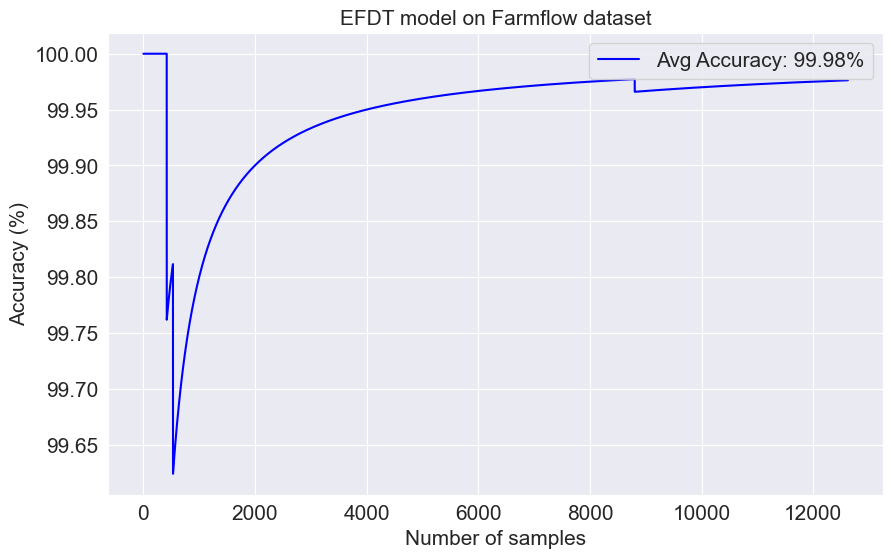

In [41]:
get_ipython().run_cell_magic('time', '', '# Use the Extremely Fast decision Tree (AMF) model with ADWIN drift detector as a baseline model\nname = "EFDT model"\n\n\nmodel=tree.ExtremelyFastDecisionTreeClassifier()\n    \n\nt, m = adaptive_learning(model, X_train, y_train, X_test, y_test) # Learn the model on the dataset\nacc_fig(t, m, name) # Draw the figure of how the real-time accuracy changes with the number of samples\n')

Accuracy: 99.98%
Precision: 99.97%
Recall: 100.0%
F1-score: 99.99%
CPU times: total: 2.45 s
Wall time: 4.66 s


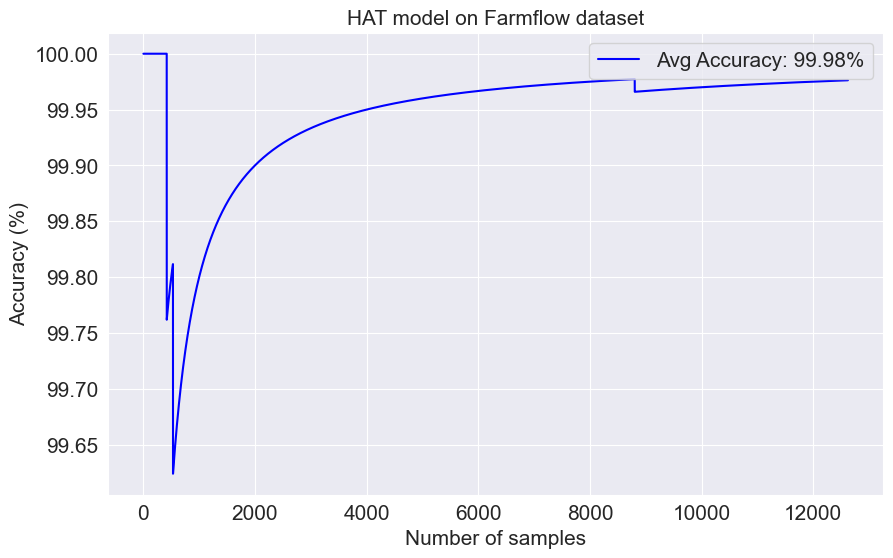

In [42]:
get_ipython().run_cell_magic('time', '', '# Use the Hoeffdinng Adaptive Tree model with ADWIN drift detector as a baseline model\nname = "HAT model"\n\n\nmodel = drift.DriftRetrainingClassifier(\n    model=tree.HoeffdingAdaptiveTreeClassifier(drift_detector=drift.binary.EDDM())\n    \n)\n\nt, m = adaptive_learning(model, X_train, y_train, X_test, y_test) # Learn the model on the dataset\nacc_fig(t, m, name) # Draw the figure of how the real-time accuracy changes with the number of samples\n')

Accuracy: 99.98%
Precision: 99.97%
Recall: 100.0%
F1-score: 99.99%
CPU times: total: 1.77 s
Wall time: 3.98 s


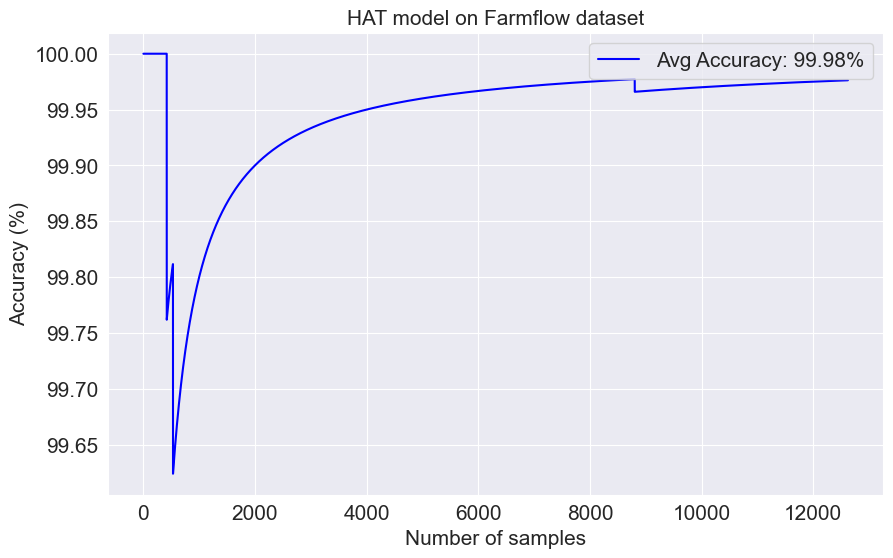

In [43]:
get_ipython().run_cell_magic('time', '', '# Use the Extremely Fast decision Tree (AMF) model with ADWIN drift detector as a baseline model\nname = "HAT model"\n\n\nmodel=tree.HoeffdingAdaptiveTreeClassifier()\n    \n\nt, m = adaptive_learning(model, X_train, y_train, X_test, y_test) # Learn the model on the dataset\nacc_fig(t, m, name) # Draw the figure of how the real-time accuracy changes with the number of samples\n')

Accuracy: 99.98%
Precision: 99.97%
Recall: 100.0%
F1-score: 99.99%
CPU times: total: 1.44 s
Wall time: 2.54 s


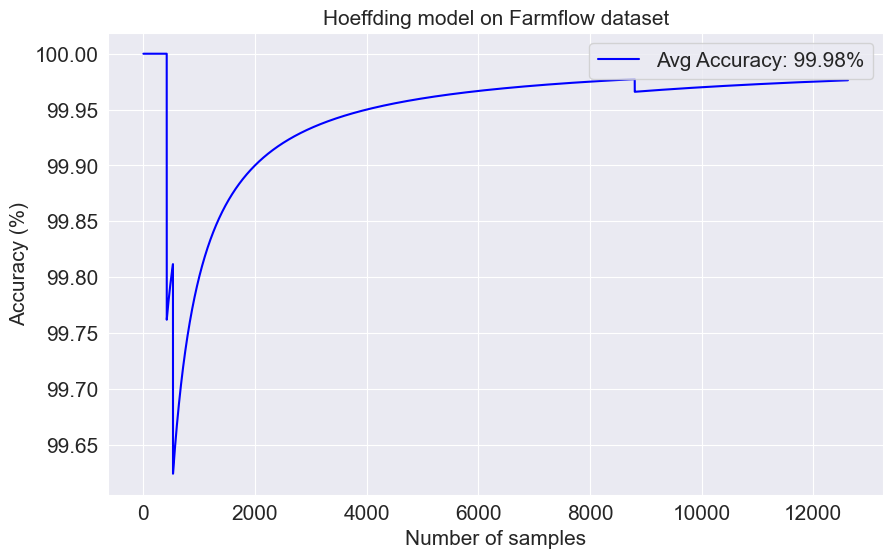

In [49]:
get_ipython().run_cell_magic('time', '', '# Use the Hoeffding Tree classifier model with ADWIN drift detector as a baseline model\nname = "Hoeffding model"\n\n\nmodel=tree.HoeffdingTreeClassifier()\n    \n\nt, m = adaptive_learning(model, X_train, y_train, X_test, y_test) # Learn the model on the dataset\nacc_fig(t, m, name) # Draw the figure of how the real-time accuracy changes with the number of samples\n')

In [50]:
from river import ensemble

Accuracy: 99.98%
Precision: 99.97%
Recall: 100.0%
F1-score: 99.99%
CPU times: total: 16 s
Wall time: 25.9 s


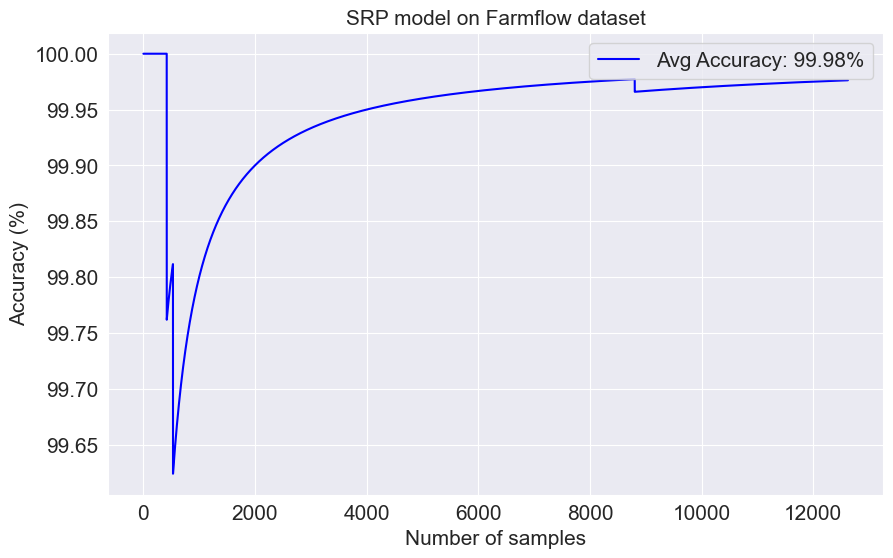

In [65]:
get_ipython().run_cell_magic('time', '', '# Use the Streaming Random Patches (SRP) model with ADWIN drift detector as a baseline model\nname = "SRP model"\n\n\nbase_model = tree.HoeffdingTreeClassifier()\n\nmodel = ensemble.SRPClassifier(\n    model=base_model, n_models=3, seed=42,\n)\n    \n\nt, m = adaptive_learning(model, X_train, y_train, X_test, y_test) # Learn the model on the dataset\nacc_fig(t, m, name) # Draw the figure of how the real-time accuracy changes with the number of samples\n')

Warning detected at index 265
Warning detected at index 266
Warning detected at index 267
Warning detected at index 268
Warning detected at index 269
Warning detected at index 270
Warning detected at index 271
Warning detected at index 272
Warning detected at index 273
Warning detected at index 274
Warning detected at index 275
Warning detected at index 276
Warning detected at index 277
Warning detected at index 278
Warning detected at index 279
Warning detected at index 280
Warning detected at index 281
Warning detected at index 282
Warning detected at index 283
Warning detected at index 284
Warning detected at index 285
Warning detected at index 286
Warning detected at index 287
Warning detected at index 288
Warning detected at index 289
Change detected at index 290, input value: 1
Warning detected at index 290
Change detected at index 291, input value: 1
Warning detected at index 291
Change detected at index 292, input value: 1
Warning detected at index 292
Change detected at index 

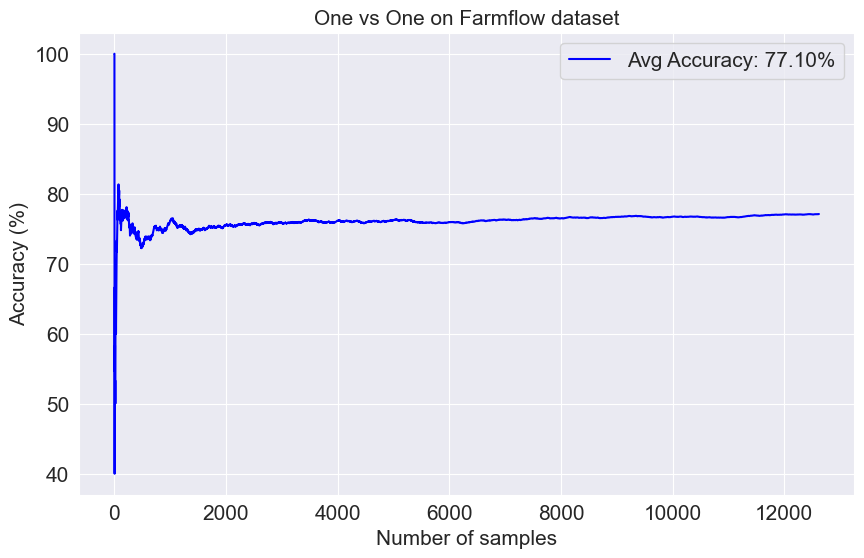

In [66]:
%%time

from river import multiclass
from river import linear_model

# Use One vs One classifier model with ADWIN drift detector as a baseline model
name = "One vs One"
model = multiclass.OneVsOneClassifier(linear_model.LogisticRegression())

t, m = adaptive_learning(model, X_train, y_train, X_test, y_test)  # Train the model
acc_fig(t, m, name)  # Plot real-time accuracy

Warning detected at index 296
Warning detected at index 297
Warning detected at index 298
Warning detected at index 299
Warning detected at index 300
Warning detected at index 301
Warning detected at index 302
Warning detected at index 303
Warning detected at index 304
Warning detected at index 305
Warning detected at index 306
Warning detected at index 307
Warning detected at index 308
Warning detected at index 309
Warning detected at index 310
Warning detected at index 311
Warning detected at index 312
Warning detected at index 313
Warning detected at index 314
Warning detected at index 315
Warning detected at index 316
Warning detected at index 317
Warning detected at index 318
Warning detected at index 319
Warning detected at index 320
Warning detected at index 321
Warning detected at index 322
Warning detected at index 323
Warning detected at index 324
Warning detected at index 325
Warning detected at index 326
Warning detected at index 327
Warning detected at index 328
Warning de

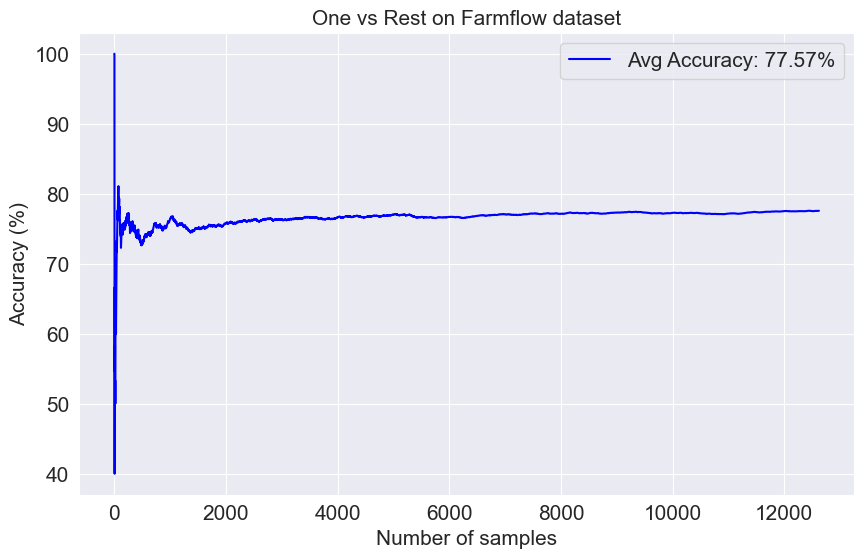

In [67]:
%%time
# Use One vs Rest classifier model with ADWIN drift detector as a baseline model
name = "One vs Rest"


model=multiclass.OneVsRestClassifier(linear_model.LogisticRegression())
    

t, m = adaptive_learning(model, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m, name) # Draw the figure of how the real-time accuracy changes with the number of samples

Warning detected at index 306
Warning detected at index 307
Warning detected at index 308
Warning detected at index 309
Warning detected at index 310
Warning detected at index 311
Warning detected at index 312
Warning detected at index 313
Warning detected at index 314
Warning detected at index 315
Warning detected at index 316
Warning detected at index 317
Warning detected at index 318
Warning detected at index 319
Warning detected at index 320
Warning detected at index 321
Warning detected at index 322
Warning detected at index 323
Warning detected at index 324
Warning detected at index 325
Warning detected at index 326
Warning detected at index 327
Warning detected at index 328
Warning detected at index 329
Warning detected at index 330
Warning detected at index 331
Warning detected at index 332
Warning detected at index 333
Warning detected at index 334
Warning detected at index 335
Warning detected at index 336
Warning detected at index 337
Warning detected at index 338
Warning de

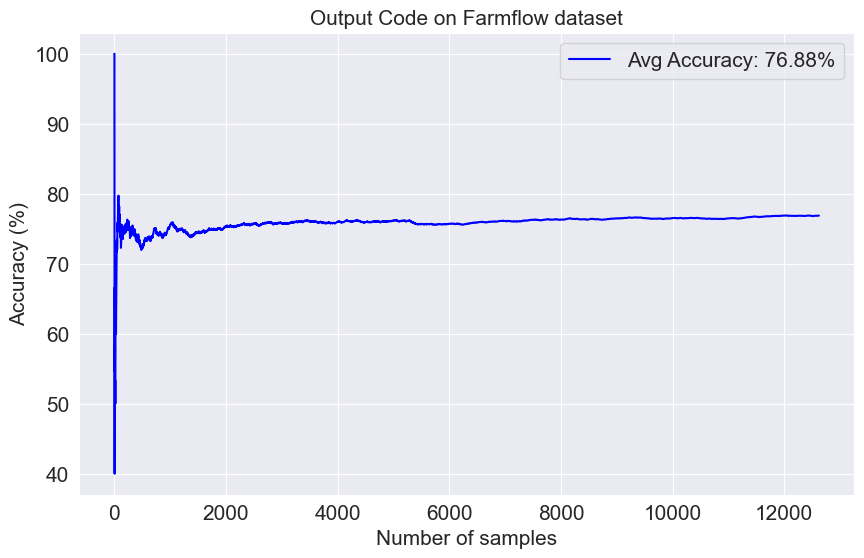

In [68]:
# Output Code Classifier with Logistic Regression
name = "Output Code"
model = multiclass.OutputCodeClassifier(linear_model.LogisticRegression(), code_size=5)

t, m = adaptive_learning(model, X_train, y_train, X_test, y_test)
acc_fig(t, m, name)

Warning detected at index 306
Warning detected at index 307
Warning detected at index 308
Warning detected at index 309
Warning detected at index 310
Warning detected at index 311
Warning detected at index 312
Warning detected at index 313
Warning detected at index 314
Warning detected at index 315
Warning detected at index 316
Warning detected at index 317
Warning detected at index 318
Warning detected at index 319
Warning detected at index 320
Warning detected at index 321
Warning detected at index 322
Warning detected at index 323
Warning detected at index 324
Warning detected at index 325
Warning detected at index 326
Warning detected at index 327
Warning detected at index 328
Warning detected at index 329
Warning detected at index 330
Warning detected at index 331
Warning detected at index 332
Warning detected at index 333
Warning detected at index 334
Warning detected at index 335
Warning detected at index 336
Warning detected at index 337
Warning detected at index 338
Warning de

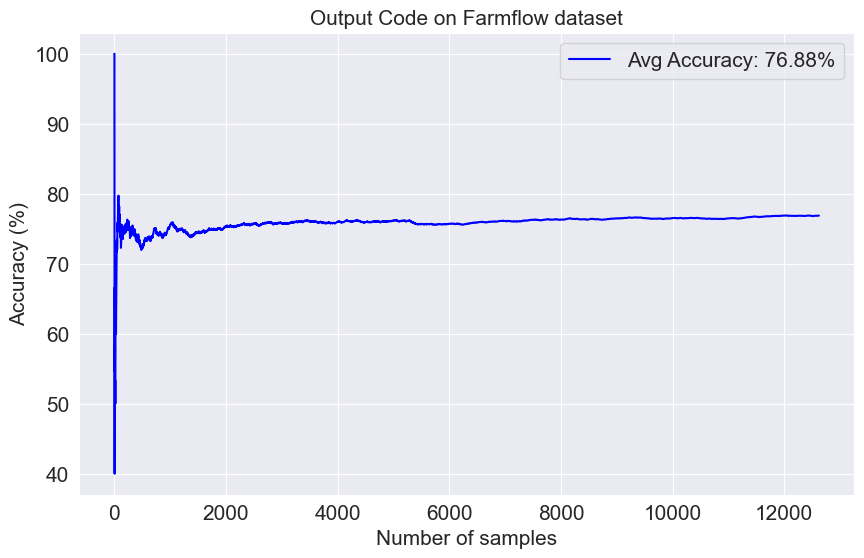

In [59]:
get_ipython().run_cell_magic('time', '', '# Output Code Classifier with Logistic Regression\nname = "Output Code"\nmodel = multiclass.OutputCodeClassifier(linear_model.LogisticRegression(),code_size=5)\n\nt, m = adaptive_learning(model, X_train, y_train, X_test, y_test)\nacc_fig(t, m, name)\n')

